In [164]:
# imports
import random as rd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy import stats
from surprise import BaselineOnly
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import NMF
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise import CoClustering
from surprise.model_selection import train_test_split, KFold

import warnings
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [165]:
# constants and initialization
dataset = 'anime' # folder of datasets: anime, ml, lfm -> if those folders are in data folder, add 'data/' in front
item_threshold = 1 # 1 means no filtering
my_seed = 0
rd.seed(my_seed)
np.random.seed(my_seed)
predict_col = 'item'
top_fraction = 0.2
folds = 5
user_events_cats_file = dataset + '/user_events_cats.txt'
low_user_file = dataset + '/low_main_users.txt'
medium_user_file = dataset + '/medium_main_users.txt'
high_user_file = dataset + '/high_main_users.txt'

save_metrics = False

cats_file = dataset + '/categories.txt'

In [166]:
cols_cats = ['user', 'item', 'preference', 'cats']
df_events_cats = pd.read_csv(user_events_cats_file, sep=',').dropna()
df_events_cats.columns = cols_cats
df_events_cats['cats'] = df_events_cats['cats'].astype(str)
df_events_cats

,user,item,preference,cats
0,201,20,5,4|10|24|9|17
1,342,20,9,4|10|24|9|17
2,761,20,5,4|10|24|9|17
3,1180,20,2,4|10|24|9|17
4,1307,20,8,4|10|24|9|17
...,...,...,...,...
649809,996,26101,7,0|11|38
649810,8965,12361,8,4|37
649811,27266,8960,6,4|10
649812,30180,14781,2,4|20|14


In [167]:
df_events_cats = df_events_cats[df_events_cats['preference'] >= item_threshold]
print('No. filtered user events: ' + str(len(df_events_cats)))
print('No. filtered items: ' + str(len(df_events_cats[predict_col].unique())))
print('No. filtered users: ' + str(len(df_events_cats['user'].unique())))

No. filtered user events: 649814
No. filtered items: 9450
No. filtered users: 3000


In [168]:
# get user distribution
user_dist = df_events_cats['user'].value_counts()
num_users = len(user_dist)
print('Mean items per user: ' + str(user_dist.mean()))
print('Min items per user: ' + str(user_dist.min()))
print('Max items per user: ' + str(user_dist.max()))

Mean items per user: 216.60466666666667
Min items per user: 50
Max items per user: 1993


In [169]:
# get item distribution
item_dist = df_events_cats[predict_col].value_counts()
num_items = len(item_dist)
print('No. items: ' + str(num_items))

No. items: 9450


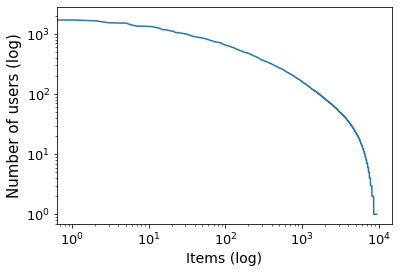

In [171]:
# plot item distribution
plt.figure()
plt.plot(item_dist.values)
plt.xlabel('Items (log)', fontsize='14')
plt.xticks(fontsize='13')
plt.yticks(fontsize='13')
plt.ylabel('Number of users (log)', fontsize='15')
plt.xscale('log')
plt.yscale('log')

In [172]:
# get top items
num_top = int(top_fraction * num_items)
top_item_dist = item_dist[:num_top]
print('No. top items: ' + str(len(top_item_dist)))

No. top items: 1890


In [173]:
# read users
low_users = pd.read_csv(low_user_file, sep=',').set_index('user')
medium_users = pd.read_csv(medium_user_file, sep=',').set_index('user')
high_users = pd.read_csv(high_user_file, sep=',').set_index('user')
no_users = len(low_users) + len(medium_users) + len(high_users)
print('No. of users: ' + str(no_users))

No. of users: 3000


Text(0.5, 1.0, 'MAL')

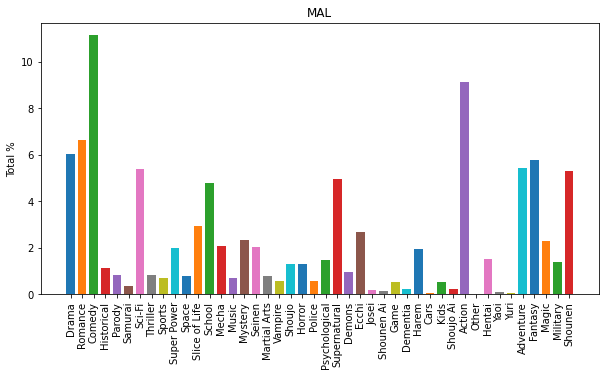

In [176]:
# Plot the distribution of genres across the dataset

df_cats = pd.read_csv(cats_file, sep=',')
df_cats.columns = ['name', 'cats']

df_cat_dist = df_events_cats.copy()
df_cat_dist.drop(['item', 'preference'], axis=1, inplace=True)
df_cat_dist["cats"] = df_cat_dist["cats"].str.split("|")
df_cat_dist = df_cat_dist.explode("cats").reset_index(drop=True)
df_cat_dist = df_cat_dist.groupby('cats').count().reset_index()#.set_index('cats')

df_cat_dist['cats'] = df_cat_dist['cats'].astype(int)
df_cats['cats'] = df_cats['cats'].astype(int)
df_cat_dist = df_cat_dist.merge(df_cats, on='cats')
df_cat_dist.set_index('cats', inplace=True)
df_cat_dist.columns = ['count', 'category']
df_cat_dist['count'] /= (df_cat_dist['count'].sum() / 100)
df_cat_dist_T = df_cat_dist.set_index('category').T
height = df_cat_dist['count'].to_list()
x = [x for x in range(len(df_cat_dist_T.columns))]

plt.figure(figsize=(10,5))
for i in range(len(x)):
    plt.bar(x=x[i], height=height[i], width=.75, label=df_cat_dist_T.columns[i])

plt.ylabel("Total %")
plt.xticks([x for x in range(len(df_cat_dist_T.columns))], labels=df_cat_dist_T.columns, rotation=90)
plt.title({'anime':'MAL', 'ml':'ML', 'lfm':'LFM'}[dataset])
# plt.savefig(dataset + '/genres.png', dpi=300, bbox_inches='tight')

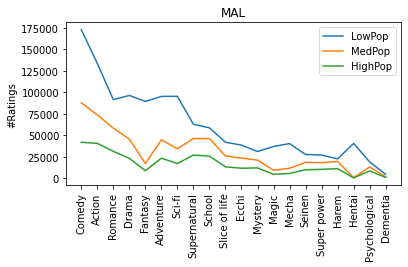

1223203
612213.0
321417.0


In [177]:
# Plot the number of total ratings per genre

# Get dataset
df_item_pop = df_events_cats.copy()
# Remove unnecessary columns
df_item_pop.drop(['item', 'preference'], axis=1, inplace=True)
# Split cat column and count their occurrence
df_item_pop["cats"] = df_item_pop["cats"].str.split("|")
df_item_pop = df_item_pop.explode("cats").reset_index(drop=True)

df_item_pop_cats = df_item_pop.groupby('cats').count().reset_index()
df_item_pop_cats.columns = ['cats', 'Total']
groups = ['LowPop', 'MedPop', 'HighPop']
for i in range(len(groups)):
    df_item_pop_group = df_item_pop.loc[df_item_pop['user'].isin([low_users, medium_users, high_users][i].index)]
    df_item_pop_cats[groups[i]] = df_item_pop_group.groupby('cats').count().reset_index()['user']

# Make sure column types are the same (needed for merge)
df_item_pop_cats['cats'] = df_item_pop_cats['cats'].astype(int)
df_cats['cats'] = df_cats['cats'].astype(int)
# Merge to get category names (str)
df_item_pop_cats = df_item_pop_cats.merge(df_cats, on='cats')
# Set cats column as index
df_item_pop_cats.set_index('cats', inplace=True)
df_item_pop_cats = df_item_pop_cats.sort_values('Total',ignore_index=True, ascending=False)

if dataset == 'anime':
    df_item_pop_cats = df_item_pop_cats.drop(range(20, 36)).reset_index(drop=True)
    df_item_pop_cats = df_item_pop_cats.drop(range(21, 28)).reset_index(drop=True)
    df_item_pop_cats = df_item_pop_cats.drop(range(7, 8)).reset_index(drop=True)
df_item_pop_cats.plot.line(y=groups, x='name', figsize=(6, 3), legend=True)
labels = [label.capitalize() for label in list(df_item_pop_cats['name'])]

plt.title({'anime':'MAL', 'ml':'ML', 'lfm':'LFM'}[dataset])
plt.xticks(ticks=range(len(labels)), labels=labels, rotation=90)
plt.ylabel("#Ratings")
plt.xlabel("")
plt.savefig(dataset+'/'+dataset+'_item_pop.pdf', dpi=300, bbox_inches='tight')
plt.show()

for i in range(len(groups)):
    print(df_item_pop_cats[groups[i]].sum())

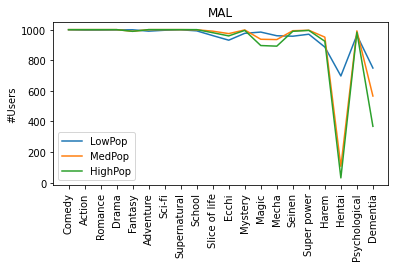

In [178]:
# Get dataset
df_item_pop = df_events_cats.copy()
# Remove unnecessary columns
df_item_pop.drop(['item', 'preference'], axis=1, inplace=True)
# Split cat column and count their occurrence
df_item_pop["cats"] = df_item_pop["cats"].str.split("|")
df_item_pop = df_item_pop.explode("cats").reset_index(drop=True)

df_item_pop_cats = df_item_pop.groupby('cats').count().reset_index()
df_item_pop_cats.columns = ['cats', 'Total']
groups = ['LowPop', 'MedPop', 'HighPop']

sum_col = 'Sum'
df_item_pop_cats[sum_col] = 0
for i in range(len(groups)):
    df_item_pop_group = df_item_pop.loc[df_item_pop['user'].isin([low_users, medium_users, high_users][i].index)]
    df_item_pop_group = df_item_pop_group.drop_duplicates(subset=['user', 'cats'])
    df_item_pop_cats[groups[i]] = df_item_pop_group.groupby('cats').count().reset_index()['user']

# Make sure column types are the same (needed for merge)
df_item_pop_cats['cats'] = df_item_pop_cats['cats'].astype(int)
df_cats['cats'] = df_cats['cats'].astype(int)
# Merge to get category names (str)
df_item_pop_cats = df_item_pop_cats.merge(df_cats, on='cats')
# Set cats column as index
df_item_pop_cats.set_index('cats', inplace=True)

df_item_pop_cats = df_item_pop_cats.sort_values('Total',ignore_index=True, ascending=False)

if dataset == 'anime':
    df_item_pop_cats = df_item_pop_cats.drop(range(20, 36)).reset_index(drop=True)
    df_item_pop_cats = df_item_pop_cats.drop(range(21, 28)).reset_index(drop=True)
    df_item_pop_cats = df_item_pop_cats.drop(range(7, 8)).reset_index(drop=True)
df_item_pop_cats.plot.line(y=groups, x='name', figsize=(6, 3), legend=True)
labels = [label.capitalize() for label in list(df_item_pop_cats['name'])]

plt.title({'anime':'MAL', 'ml':'ML', 'lfm':'LFM'}[dataset])
plt.xticks(ticks=range(len(labels)), labels=labels, rotation=90)
plt.ylabel("#Users")
plt.xlabel("")
plt.savefig(dataset+'/'+dataset+'_user_genres.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [179]:
# get pop fractions
pop_count = [] # number of top items per user
user_hist = [] # user history sizes
pop_frac = [] # relative number of top items per user
pop_frac_g = {
        'low_users': [],
        'medium_users': [],
        'high_users': []
    }
pop_item_frac = [] # average popularity of items in user profiles
low_profile_size = 0
low_gap = 0
medium_profile_size = 0
medium_gap = 0
high_profile_size = 0
high_gap = 0
low_count = 0
med_count = 0
high_count = 0
df_gap_p = pd.DataFrame(columns=['user', 'gap_p'])
df_gap_p_items = pd.DataFrame(columns=['user', 'item', 'gap_p'])
for u, df in df_events_cats.groupby('user'):
    no_user_items = len(set(df[predict_col])) # profile size
    no_user_pop_items = len(set(df[predict_col]) & set(top_item_dist.index)) # top items in profile
    pop_count.append(no_user_pop_items)
    user_hist.append(no_user_items)
    pop_frac.append(no_user_pop_items / no_user_items)
    # get popularity (= fraction of users interacted with item) of user items and calculate average of it
    user_pop_item_frac = sum(item_dist[df[predict_col]] / no_users) / no_user_items
    pop_item_frac.append(user_pop_item_frac)
    df_gap_p = pd.concat([df_gap_p, pd.DataFrame.from_dict({'user': [u], 'gap_p': [user_pop_item_frac]})], ignore_index=True)

    item_list = list(df[predict_col])
    df_gap_p_items = pd.concat([df_gap_p_items, pd.DataFrame.from_dict({'user': [u for _ in item_list], 'item': item_list, 'gap_p': [user_pop_item_frac for _ in item_list]})], ignore_index=True)
    if u in low_users.index: # get user group-specific values
        pop_frac_g['low_users'].append(no_user_pop_items / no_user_items)
        low_profile_size += no_user_items
        low_gap += user_pop_item_frac
        low_count += 1
    elif u in medium_users.index:
        pop_frac_g['medium_users'].append(no_user_pop_items / no_user_items)
        medium_profile_size += no_user_items
        medium_gap += user_pop_item_frac
        med_count += 1
    else:
        pop_frac_g['high_users'].append(no_user_pop_items / no_user_items)
        high_profile_size += no_user_items
        high_gap += user_pop_item_frac
        high_count += 1
low_profile_size /= len(low_users)
medium_profile_size /= len(medium_users)
high_profile_size /= len(high_users)
low_gap /= len(low_users)
medium_gap /= len(medium_users)
high_gap /= len(high_users)
print('Low count (for check): ' + str(low_count))
print('Med count (for check): ' + str(med_count))
print('High count (for check): ' + str(high_count))

Low count (for check): 1000
Med count (for check): 1000
High count (for check): 1000


In [180]:
print('Average LowMS profile size: ' + str(low_profile_size))
print('Average MedMS profile size: ' + str(medium_profile_size))
print('Average HighMS profile size: ' + str(high_profile_size))

Average LowMS profile size: 391.326
Average MedMS profile size: 172.71
Average HighMS profile size: 85.778


Average % of popular items per user:  82.85363319214947
Standard deviation of % of popular items per user:  17.927436992669765


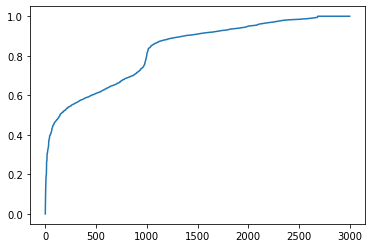

In [181]:
# calculate % of popular items each user interacted with
pop_item_pct = [p * 100 for p in pop_frac]

# calculate average and standard deviation of % of popular items each user interacted with
avg_pop_item_pct = np.mean(pop_item_pct)
std_pop_item_pct = np.std(pop_item_pct)

print("Average % of popular items per user: ", avg_pop_item_pct)
print("Standard deviation of % of popular items per user: ", std_pop_item_pct)

plt.plot(sorted(pop_frac))

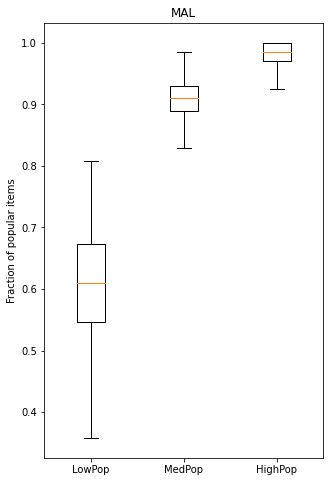

In [182]:
# Create a boxplot to visualize the ratio of popular items of user profiles for each group
fig, ax = plt.subplots(figsize=(5, 8))
ax.boxplot([pop_frac_g['low_users'], pop_frac_g['medium_users'], pop_frac_g['high_users']], labels=['LowPop', 'MedPop', 'HighPop'], showfliers=False)
#ax.set_title('Fraction of Popular Items by User Group')
ax.set_ylabel('Fraction of popular items')
#ax.set_xlabel('User Group')

plt.title({'anime':'MAL', 'ml':'ML', 'lfm':'LFM'}[dataset])
plt.savefig(f'{dataset}/{dataset}_pop_frac_boxplot.pdf', dpi=300, bbox_inches='tight')
plt.show()

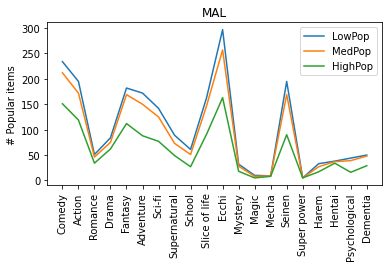

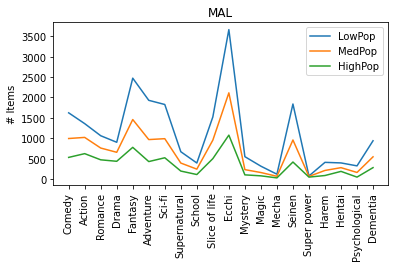

In [183]:
# Plot the number of distinct items per genre
def plot_distinct_items(name):
    df_item = df_item_pop_cats.drop(groups, axis=1).copy()
    for i_group, group_name in enumerate(groups):
        df_events_group = df_events_cats.loc[df_events_cats['user'].isin([low_users, medium_users, high_users][i_group].index)].copy()
        if name == 'top':
            df_events_group = df_events_group.loc[df_events_group[predict_col].isin(item_dist.values)]
        df_events_group.drop(['user', 'preference'], axis=1, inplace=True)
        df_events_group.drop_duplicates(inplace=True)
        df_events_group["cats"] = df_events_group["cats"].str.split("|")
        df_events_group  = df_events_group.explode("cats").reset_index(drop=True)
        df_item_count = df_events_group.groupby('cats')['item'].nunique().reset_index()
        df_item_count.columns = ['cats', group_name]
        df_item_count['cats'] = df_item_count['cats'].astype(int)
        df_item = df_item.merge(df_item_count.set_index('cats'), left_index=True, right_index=True)

    df_item = df_item.sort_values('Total',ignore_index=True, ascending=False)
    df_item.plot.line(y=groups, x='name', figsize=(6, 3), legend=True)
    plot_labels = [label.capitalize() for label in list(df_item['name'])]

    plt.title({'anime':'MAL', 'ml':'ML', 'lfm':'LFM'}[dataset])
    plt.xticks(ticks=range(len(plot_labels)), labels=plot_labels, rotation=90)
    plt.ylabel("# Items" if name == 'all' else '# Popular items')
    plt.xlabel("")
    plt.savefig(f'{dataset}/{dataset}_distinct_items_genres_{name}.pdf', dpi=300, bbox_inches='tight')
    plt.show()

plot_distinct_items('top')
plot_distinct_items('all')

## Recommendations using Surprise package


In [184]:
#df_events = scaled_df_events
print('Min rating: ' + str(df_events_cats['preference'].min()))
print('Max rating: ' + str(df_events_cats['preference'].max()))

Min rating: 1
Max rating: 10


In [185]:
reader = Reader(rating_scale=(df_events_cats['preference'].min(), df_events_cats['preference'].max()))

In [186]:
# remove cats column, as it is not used to predict a recommendation
data = Dataset.load_from_df(df_events_cats[df_events_cats.columns[:-1]], reader)
kf = KFold(n_splits=folds, random_state=my_seed, shuffle=True)

In [187]:
def get_top_n(predictions, n=10):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n

In [188]:
def get_top_n_random(testset, n=10):
    top_n = defaultdict(list)
    for uid, iid, true_r in testset:
        if len(top_n[uid]) == 0:
            for i in range(0, 10):
                top_n[uid].append((rd.choice(item_dist.index), i))
    return top_n

In [189]:
def get_top_n_mp(testset, n=10):
    top_n = defaultdict(list)
    for uid, iid, true_r in testset:
        if len(top_n[uid]) == 0:
            for iid, count in item_dist[:n].items():
                top_n[uid].append((iid, count))
    return top_n

In [190]:
def get_mae_of_groups(predictions):
    low_predictions = []
    med_predictions = []
    high_predictions = []
    dict_maes = {'user': [], 'item': [], 'mae': []}
    for uid, iid, true_r, est, details in predictions:
        prediction = [(uid, iid, true_r, est, details)]
        dict_maes['user'].append(uid)
        dict_maes['item'].append(iid)
        dict_maes['mae'].append(accuracy.mae(prediction, verbose=False))

        if uid in low_users.index:
            low_predictions.append(accuracy.mae(prediction, verbose=False))
        elif uid in medium_users.index:
            med_predictions.append(accuracy.mae(prediction, verbose=False))
        elif uid in high_users.index:
            high_predictions.append(accuracy.mae(prediction, verbose=False))

    return pd.DataFrame.from_dict(dict_maes), [low_predictions, med_predictions, high_predictions]

In [191]:
def g_precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user group"""

    # Filter predictions for each group
    low_user_preds = []
    medium_user_preds = []
    high_user_preds = []
    for uid, iid, true_r, est, details in predictions:
        prediction = (uid, iid, true_r, est, details)
        if uid in low_users.index:
            low_user_preds.append(prediction)
        elif uid in medium_users.index:
            medium_user_preds.append(prediction)
        elif uid in high_users.index:
            high_user_preds.append(prediction)

    # Calculate precision and recall for each group
    low_user_precisions, low_user_recalls = precision_recall_at_k(low_user_preds, k=k, threshold=threshold)
    medium_user_precisions, medium_user_recalls = precision_recall_at_k(medium_user_preds, k=k, threshold=threshold)
    high_user_precisions, high_user_recalls = precision_recall_at_k(high_user_preds, k=k, threshold=threshold)

    return {
        'low_users': (low_user_precisions, low_user_recalls),
        'medium_users': (medium_user_precisions, medium_user_recalls),
        'high_users': (high_user_precisions, high_user_recalls)
    }

In [192]:
# From: https://surprise.readthedocs.io/en/stable/FAQ.html#how-to-compute-prec
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

In [193]:
# create item dataframe with normalized item counts
df_item_dist = pd.DataFrame(item_dist)
df_item_dist.columns = ['count']
df_item_dist['count'] /= no_users

In [194]:
sim_users = {'name': 'cosine', 'user_based': True}  # compute cosine similarities between users
algos = [BaselineOnly(verbose=False),
         KNNBasic(sim_options=sim_users, verbose=False),
         KNNWithMeans(sim_options=sim_users, verbose=False),
         NMF(n_factors=30, random_state=my_seed),
         CoClustering(n_cltr_u=3, n_cltr_i=3, random_state=my_seed)]
algo_names = ['UserItemAvg',
              'UserKNN',
              'UserKNNAvg',
              'NMF',
              'Co-Custering']

In [195]:
q = [{} for _ in range(folds)]
maes = {}
maes_user = {}
low_rec_gap_list = [] # one entry per algorithm
medium_rec_gap_list = []
high_rec_gap_list = []
gaps_q = {}
for i in range(0, len(algo_names)):
    print(algo_names[i])

    df_item_dist[algo_names[i]] = 0
    low_rec_gaps = [0 for _ in range(folds)]
    medium_rec_gaps = [0 for _ in range(folds)]
    high_rec_gaps = [0 for _ in range(folds)]

    fold = 0
    mae_list = []
    predictions_maes = [0 for _ in range(3)]
    precisions_list = {
        'low_users': [],
        'medium_users': [],
        'high_users': []
    }
    recalls_list = {
        'low_users': [],
        'medium_users': [],
        'high_users': []
    }
    num_users_with_ten_or_more_items = []
    for trainset, testset in kf.split(data):
        df_item_count_per_user = pd.DataFrame(testset, columns=['user', 'item', 'preference'])
        user_counts = df_item_count_per_user.groupby('user').size()
        num_users_with_ten_or_more_items.append((user_counts >= 10).sum())

        # get accuracy for personalized approaches
        algos[i].fit(trainset)
        predictions = algos[i].test(testset, verbose=False)

        # calculate precision and recall per group
        threshold = df_item_count_per_user['preference'].mean()#{'anime':7, 'ml':3.5, 'lfm':700}[dataset]
        for group, (precisions, recalls) in g_precision_recall_at_k(predictions, k=5, threshold=threshold).items():
            precisions_list[group].append(sum(prec for prec in precisions.values()) / len(precisions))
            recalls_list[group].append(sum(rec for rec in recalls.values()) / len(recalls))

        mae_list.append(accuracy.mae(predictions, verbose=False))
        df_mae, predictions_mae = get_mae_of_groups(predictions)
        if algo_names[i] not in maes:
            maes[algo_names[i]] = df_mae
            maes[algo_names[i]]['mae'] /= folds
        else:
            maes[algo_names[i]]['mae'] += df_mae['mae'] / folds

        predictions_maes = [predictions_maes[i] + np.mean(predictions_mae[i])/folds for i in range(3)]
        # Test for significance of mae
        # print(stats.ttest_ind(predictions_mae[0], predictions_mae[1]))
        # print(stats.ttest_ind(predictions_mae[0], predictions_mae[2]))

        top_n = get_top_n(predictions, n=10)
        q[fold][algo_names[i]] = top_n.items()

        low_count = 0
        med_count = 0
        high_count = 0
        dict_gap_q = {'user':[], 'gap_q':[]}
        for uid, user_ratings in top_n.items():
            iid_list = []
            for (iid, _) in user_ratings:
                df_item_dist.loc[iid, algo_names[i]] += 1
                iid_list.append(iid)
            gap = sum(item_dist[iid_list] / no_users) / len(iid_list)
            dict_gap_q['user'].append(uid)
            dict_gap_q['gap_q'].append(gap / folds)
            if uid in low_users.index:
                low_rec_gaps[fold] += gap
                low_count += 1
            elif uid in medium_users.index:
                medium_rec_gaps[fold] += gap
                med_count += 1
            elif uid in high_users.index:
                high_rec_gaps[fold] += gap
                high_count += 1

        if algo_names[i] not in gaps_q:
            gaps_q[algo_names[i]] = pd.DataFrame.from_dict(dict_gap_q)
        else:
            gaps_q[algo_names[i]]['gap_q'] += pd.DataFrame.from_dict(dict_gap_q)['gap_q']
        low_rec_gaps[fold] /= low_count
        medium_rec_gaps[fold] /= med_count
        high_rec_gaps[fold] /= high_count
        # check, if all users are used
        # print('#User:', low_count, med_count, high_count)
        fold += 1

    low_rec_gap_list.append(np.mean(low_rec_gaps))
    medium_rec_gap_list.append(np.mean(medium_rec_gaps))
    high_rec_gap_list.append(np.mean(high_rec_gaps))

    maes_user[algo_names[i]] = maes[algo_names[i]].drop(['item'], axis=1)
    for group in precisions_list.keys():
        print(f'Mean precisions ({group}): {np.mean(precisions_list[group])}')
        print(f'Mean recalls ({group}): {np.mean(recalls_list[group])}')
    print(stats.ttest_ind(precisions_list['low_users'], precisions_list['medium_users']))
    print(stats.ttest_ind(precisions_list['low_users'], precisions_list['high_users']))
    print(stats.ttest_ind(recalls_list['low_users'], recalls_list['medium_users']))
    print(stats.ttest_ind(recalls_list['low_users'], recalls_list['high_users']))
    print(f'Average #user \w >=10 #items: {np.mean(num_users_with_ten_or_more_items)}')

    i += 1 # next algorithm

UserItemAvg
Mean precisions (low_users): 0.7114366666666655
Mean recalls (low_users): 0.14514961903770265
Mean precisions (medium_users): 0.8021233333333317
Mean recalls (medium_users): 0.21520728850513554
Mean precisions (high_users): 0.8117899999999985
Mean recalls (high_users): 0.33804967260568575
Ttest_indResult(statistic=-22.286546633965973, pvalue=1.7373649288049963e-08)
Ttest_indResult(statistic=-23.424626945318384, pvalue=1.1727456255897651e-08)
Ttest_indResult(statistic=-54.83892224079212, pvalue=1.3562915908879919e-11)
Ttest_indResult(statistic=-69.74406504600732, pvalue=1.988798068415834e-12)
Average #user \w >=10 #items: 2834.6
UserKNN
Mean precisions (low_users): 0.7258766666666658
Mean recalls (low_users): 0.16369947001499904
Mean precisions (medium_users): 0.8045166666666651
Mean recalls (medium_users): 0.2322816791866973
Mean precisions (high_users): 0.8128199999999982
Mean recalls (high_users): 0.3596919261146647
Ttest_indResult(statistic=-24.98542095609272, pvalue=7.0

In [196]:
d_predictions = [{} for _ in range(folds)]
for fold in range(folds):
    for i in range(len(algo_names)):
        df_a = pd.DataFrame(q[fold][algo_names[i]], columns=['user', 'item_ratings'])
        df_a = df_a.explode('item_ratings')
        df_a[['item', 'rank']] = pd.DataFrame(df_a['item_ratings'].tolist(), index=df_a.index)
        df_a.drop('item_ratings', axis=1, inplace=True)
        df_a.sort_values('rank', ascending=False, inplace=True)
        d_predictions[fold][algo_names[i]] = df_a

d_predictions[0][algo_names[2]].head()

,user,item,rank
2008,36707,9253,10.0
2548,36985,6547,10.0
2874,34547,1520,10.0
2215,56448,31240,10.0
1273,55440,3297,10.0


In [197]:
low_pl_vals = []
medium_pl_vals = []
high_pl_vals = []
pls = {}
pls_items = {}
for i in range(0, len(algos)):
    print(algo_names[i])
    pl_low = (low_rec_gap_list[i] - low_gap) / low_gap
    pl_med = (medium_rec_gap_list[i] - medium_gap) / medium_gap
    pl_high = (high_rec_gap_list[i] - high_gap) / high_gap
    print('LowPop:', pl_low)
    print('MedPop:', pl_med)
    print('HighPop:', pl_high)

    low_pl_vals.append(pl_low)# * 100)
    medium_pl_vals.append(pl_med)# * 100)
    high_pl_vals.append(pl_high)# * 100)

    df_gap = gaps_q[algo_names[i]].merge(df_gap_p, on=['user'])
    df_gap['pl'] = 0
    # Filter "user" values based on the index of the low, medium, and high user dataframes
    df_gap.loc[df_gap['user'].isin(low_users.index), 'pl'] = pl_low
    df_gap.loc[df_gap['user'].isin(medium_users.index), 'pl'] = pl_med
    df_gap.loc[df_gap['user'].isin(high_users.index), 'pl'] = pl_high
    pls[algo_names[i]] = df_gap[['user', 'pl']]

    df_gap_items = df_gap_p_items.merge(gaps_q[algo_names[i]], on=['user'])
    df_gap_items['pl'] = 0
    # Filter "user" values based on the index of the low, medium, and high user dataframes
    df_gap_items.loc[df_gap_items['user'].isin(low_users.index), 'pl'] = pl_low
    df_gap_items.loc[df_gap_items['user'].isin(medium_users.index), 'pl'] = pl_med
    df_gap_items.loc[df_gap_items['user'].isin(high_users.index), 'pl'] = pl_high
    pls_items[algo_names[i]] = df_gap_items[['user', 'item', 'pl']]

    print(stats.ttest_ind(df_gap_items.loc[df_gap_items['user'].isin(low_users.index)]['pl'], df_gap_items.loc[df_gap_items['user'].isin(medium_users.index)]['pl']))
    print(stats.ttest_ind(df_gap_items.loc[df_gap_items['user'].isin(low_users.index)]['pl'], df_gap_items.loc[df_gap_items['user'].isin(high_users.index)]['pl']))
    print('----------------------')


UserItemAvg
LowPop: 1.1201052599489505
MedPop: 0.4184278606202499
HighPop: 0.15272731825470412
Ttest_indResult(statistic=1.2955272353069038e+18, pvalue=0.0)
Ttest_indResult(statistic=1.2759774596543905e+18, pvalue=0.0)
----------------------
UserKNN
LowPop: 0.739706745237051
MedPop: 0.22688502783847578
HighPop: 0.08405054492013984
Ttest_indResult(statistic=1.9196150715307684e+18, pvalue=0.0)
Ttest_indResult(statistic=1.7296291280361708e+18, pvalue=0.0)
----------------------
UserKNNAvg
LowPop: 0.5381037262921635
MedPop: 0.2462764348885638
HighPop: 0.11049593359836478
Ttest_indResult(statistic=5.2999071529628634e+17, pvalue=0.0)
Ttest_indResult(statistic=5.6019307096134835e+17, pvalue=0.0)
----------------------
NMF
LowPop: 0.8637321036269492
MedPop: 0.3508448041411125
HighPop: 0.12945350445811615
Ttest_indResult(statistic=1.3599189822196326e+18, pvalue=0.0)
Ttest_indResult(statistic=1.9239021853099666e+18, pvalue=0.0)
----------------------
Co-Custering
LowPop: 1.0954209543836608
MedPo

## Miscalibration Metric
Here we calculate the miscalibration metric. This metric is a derivate of the well-known Kullback-Leibler (KL) divergence which has been modified.

In [198]:
# Calculate p(c|u)
def calc_pcu(df_events_):
    cols_pcu = ['user', 'cat', 'metric']
    df_events = df_events_.copy()

    cols_weights = ['user', 'sum']
    s_weights_sum = df_events.groupby('user')['preference'].sum().reset_index()
    s_weights_sum.columns = cols_weights

    df_events["cats"] = df_events["cats"].str.split("|")
    df_events_split = df_events.explode("cats").reset_index(drop=True)
    df_events_split["count"] = df_events_split.groupby(['user','item'])["cats"].transform('count')

    df_events_split["wipci"] = df_events_split["preference"] / df_events_split["count"]

    df_dist = df_events_split.groupby(['user', 'cats'])['wipci'].sum().to_frame().reset_index()

    df_msc = df_dist.merge(s_weights_sum, on=['user'])
    df_msc[['wipci']] = df_msc[['wipci']].div(df_msc['sum'], axis=0)
    df_msc.drop('sum', axis=1, inplace=True)
    df_msc.columns = cols_pcu
    return df_msc

In [199]:
df_pcu = calc_pcu(df_events_cats)
df_pcu.head()

,user,cat,metric
0,179,0,0.119834
1,179,1,0.068416
2,179,10,0.096781
3,179,11,0.015186
4,179,12,0.010270


In [200]:
# Calculate q(c|u)
def calc_qcu(df_predictions_, df_item_cats_):
    # drop rows in ignore list
    # group by user id and artist
    df_predictions = df_predictions_.copy()
    df_item_cats = df_item_cats_.copy()
    df_predictions['user'] = df_predictions['user'].astype(int)
    df_predictions['item'] = df_predictions['item'].astype(int)
    df_item_cats['cats'] = df_item_cats['cats'].astype(str)

    df_predictions['rank'] = df_predictions['rank'].astype(float)
    # calc mean if item is recommended multiple times
    df_predictions = df_predictions.groupby(['user', 'item'])['rank'].mean().reset_index(name='preference')
    # Calculate sum of weights
    s_weights_sum = df_predictions.groupby('user')['preference'].sum().reset_index()
    s_weights_sum.columns = cols_weights
    # Split user_predictions genres into rows
    df_predictions = df_predictions.merge(df_item_cats,on='item', how='left')#.reset_index()
    df_predictions['cats'] = df_predictions['cats'].astype(str)
    df_predictions["cats"] = df_predictions["cats"].str.split("|")
    df_predictions = df_predictions.explode("cats").reset_index(drop=True)
    df_predictions["count"] = df_predictions.groupby(['user','item'])["cats"].transform('count')
    # calculate weighted p(c|i)
    # wi * pci, wi -> preference(rank), pci -> 1/count
    df_predictions["wipci"] = df_predictions["preference"] / df_predictions["count"]
    # Sum up genres
    df_dist = df_predictions.groupby(['user', 'cats'])['wipci'].sum().to_frame().reset_index()
    # Divide by sum of weights
    df_dist = df_dist.merge(s_weights_sum, on=['user'])
    df_dist['wipci'] /= df_dist['sum']
    df_dist.drop('sum', axis=1, inplace=True)
    df_dist.columns = cols_msc
    df_dist = df_dist[df_dist.astype(str)['cat'] != 'nan']
    return df_dist

In [201]:
df_item_cats = df_events_cats.copy()
df_item_cats.drop(['user', 'preference'], axis=1, inplace=True)
df_item_cats.drop_duplicates(inplace=True)
df_item_cats

,item,cats
0,20,4|10|24|9|17
1288,59,10|0|31|1|14|23
2023,64,4|10|0|7|23
2387,65,4|10|0|7|23
2636,97,4|5|14
...,...,...
649809,26101,0|11|38
649810,12361,4|37
649811,8960,4|10
649812,14781,4|20|14


In [202]:
df_user_cats = df_events_cats[['user', 'cats']].copy()
df_user_cats['cats'] = df_user_cats['cats'].astype(str)
df_user_cats["cats"] = df_user_cats["cats"].str.split("|")
df_user_cats = df_user_cats.explode("cats").reset_index(drop=True)
df_user_cats.drop_duplicates(inplace=True)

In [203]:
df_qcu = [{} for _ in range(folds)]
cols_weights = ['user', 'sum']
cols_msc = ['user', 'cat', 'metric']
for fold in range(folds):
    for i in range(0, len(algo_names)):
        df_msc = calc_qcu(d_predictions[fold][algo_names[i]], df_item_cats)
        df_qcu[fold][algo_names[i]] = df_msc

In [204]:
alpha = .01

# 𝛼 · 𝑝(𝑐|𝑢)
df_pcu_a = df_pcu.copy()
df_pcu_a.loc[:,'metric'] *= alpha
df_pcu_a['user']=df_pcu_a['user'].astype(int)
df_pcu_a['cat']=df_pcu_a['cat'].astype(int)

df_pcu_a

,user,cat,metric
0,179,0,0.001198
1,179,1,0.000684
2,179,10,0.000968
3,179,11,0.000152
4,179,12,0.000103
...,...,...,...
103357,73426,5,0.000678
103358,73426,6,0.000445
103359,73426,7,0.000196
103360,73426,8,0.000163


In [205]:
df_pcu_a.loc[df_pcu_a['user'] == 3]['metric'].sum()

0.0

In [206]:
# Calculate the miscalibration metric for each algorithm.
def calc_MCkl(df_qcu_, df_pcu_a, df_pcu):
    cols_q_head = ['user', 'cat']

    # (1 − 𝛼) · 𝑞(𝑐|𝑢)
    df_qcu = df_qcu_.copy()
    df_qcu.loc[:,'metric'] *= (1 - alpha)
    df_qcu['user'] = df_qcu['user'].astype(int)
    df_qcu['cat'] = df_qcu['cat'].astype(int)

    # 𝑞˜(𝑐|𝑢) allmusic
    df_q_head = df_pcu_a.join(df_qcu.set_index(cols_q_head), on=cols_q_head, lsuffix='_left', rsuffix='_right').fillna(0)
    df_q_head['q_head'] = df_q_head['metric_left'] + df_q_head['metric_right']
    df_pcu['cat'] = df_pcu['cat'].astype(int)
    df_q_head = df_q_head.join(df_pcu.set_index(cols_q_head), on=cols_q_head)

    # calculate MC_kl allmusic
    df_q_head['mc'] = df_q_head['metric'] * np.log(df_q_head['metric']/ df_q_head['q_head'])

    l_cat_mc = []
    for group in [low_users, medium_users, high_users]:
        l_cat_mc.append(df_q_head.loc[df_q_head['user'].isin(group.index)].drop('user', axis=1).groupby('cat')['mc'].mean())

    df_MC_kl = df_q_head.groupby('user')['mc'].sum().reset_index()
    return df_MC_kl, l_cat_mc


In [207]:
cols_q_head = ['user', 'cat']
MC_kl_d = {}
MC_cat_d = {}
df_metrics = pd.DataFrame()
df_metrics_low = pd.DataFrame()
df_metrics_med = pd.DataFrame()
df_metrics_high = pd.DataFrame()
# for each algo (UserItem, KNN, ...)
for i in range(0, len(algo_names)):
    print(algo_names[i])
    print('--------------------------------------')

    l_cat_mcs = [0 for _ in range(3000)]
    MC_kl = None
    for fold in range(folds):
        df_mc, list_cat_mc = calc_MCkl(df_qcu[fold][algo_names[i]], df_pcu_a, df_pcu)
        if MC_kl is None:
            MC_kl = df_mc
            MC_kl['mc'] /= folds
        else:
            MC_kl['mc'] += df_mc['mc'] / folds
        l_cat_mcs = [l_cat_mcs[i] + list_cat_mc[i]/folds for i in range(len(list_cat_mc))]

    print(MC_kl.head())
    print('--------------------------------------')
    print('Avg Total', MC_kl['mc'].mean())
    print('Avg Low', MC_kl.loc[MC_kl['user'].isin(low_users.index)]['mc'].mean())
    print('Avg Med', MC_kl.loc[MC_kl['user'].isin(medium_users.index)]['mc'].mean())
    print('Avg High', MC_kl.loc[MC_kl['user'].isin(high_users.index)]['mc'].mean())
    print('95%', stats.t.interval(alpha=0.95, df=len(MC_kl['mc'].tolist())-1, loc=np.mean(MC_kl['mc'].tolist()), scale=stats.sem(MC_kl['mc'].tolist())))

    MC_kl_d[algo_names[i]] = MC_kl
    df_metrics[algo_names[i]] = MC_kl['mc']
    MC_cat_d[algo_names[i]] = l_cat_mcs

    df_metrics_low[algo_names[i]] = MC_kl.loc[MC_kl['user'].isin(low_users.index)]['mc']
    df_metrics_med[algo_names[i]] = MC_kl.loc[MC_kl['user'].isin(medium_users.index)]['mc']
    df_metrics_high[algo_names[i]] = MC_kl.loc[MC_kl['user'].isin(high_users.index)]['mc']

    print(stats.ttest_ind(MC_kl.loc[MC_kl['user'].isin(low_users.index)]['mc'], MC_kl.loc[MC_kl['user'].isin(medium_users.index)]['mc']))
    print(stats.ttest_ind(MC_kl.loc[MC_kl['user'].isin(low_users.index)]['mc'], MC_kl.loc[MC_kl['user'].isin(high_users.index)]['mc']))

    print('======================================\n')

UserItemAvg
--------------------------------------
   user        mc
0   179  0.703424
1   201  2.298314
2   247  0.589237
3   342  0.978886
4   488  0.744365
--------------------------------------
Avg Total 0.7797919179908981
Avg Low 0.9557687841203719
Avg Med 0.7375067338857537
Avg High 0.6461002359665684
95% (0.7700453086892385, 0.7895385272925577)
Ttest_indResult(statistic=17.303102114735214, pvalue=1.2961490144354173e-62)
Ttest_indResult(statistic=25.048726711965784, pvalue=1.1855518264282397e-120)

UserKNN
--------------------------------------
   user        mc
0   179  0.712129
1   201  2.118168
2   247  0.548298
3   342  1.101622
4   488  0.719253
--------------------------------------
Avg Total 0.7578904971774206
Avg Low 0.9185055935197081
Avg Med 0.7206355865018037
Avg High 0.6345303115107501
95% (0.7490299102349868, 0.7667510841198545)
Ttest_indResult(statistic=17.402080065756927, pvalue=2.8993389314223345e-63)
Ttest_indResult(statistic=25.58689568566826, pvalue=3.863259474

In [208]:
# Saves the calculated metrics for each algorithm
users = pd.concat([low_users, medium_users, high_users])
for i in range(len(algo_names)):
    if save_metrics:
        maes_user[algo_names[i]].loc[maes_user[algo_names[i]]['user'].isin(users.index)].groupby('user')['mae'].mean().reset_index().merge(pls[algo_names[i]].loc[pls[algo_names[i]]['user'].isin(users.index)], on='user').merge(MC_kl_d[algo_names[i]].loc[MC_kl_d[algo_names[i]]['user'].isin(users.index)], on='user').to_csv(  algo_names[i] + '.csv', sep=';')

## Genre miscalibration sorted by count

Only a few genres are responsible for the high miscalibration value of certain groups. This is due to user profiles having an unproportionate amount of pertaining to these genres. We therefore will also not see any or only a weak correlation with the popularity lift metric, as those (popular) genres may not be the same as the ones creating a high miscalibration.

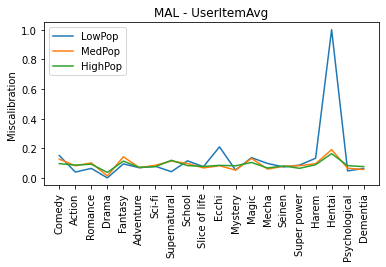

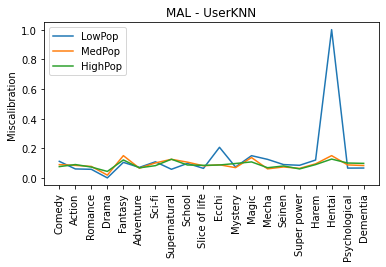

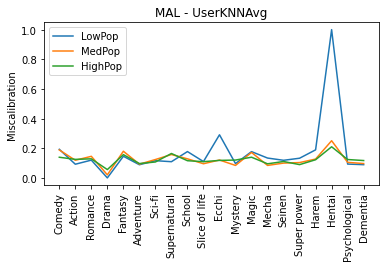

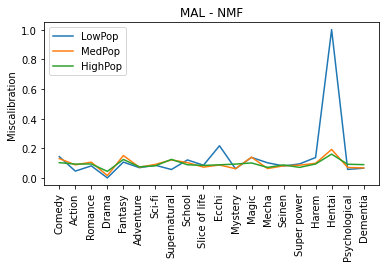

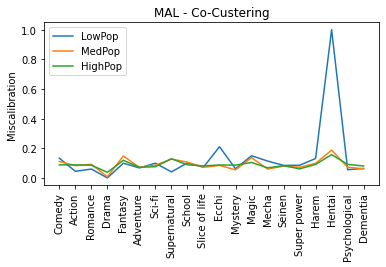

In [213]:
for selected_algorithm in range(len(algo_names)):
    df_user_cats_mc = pd.merge(df_user_cats, MC_kl_d[algo_names[selected_algorithm]], on='user')

    df_genre_mc_count = df_cat_dist.copy(deep=True)
    groups = ['LowPop', 'MedPop', 'HighPop']
    min_value = 1000
    max_value = 0
    for i, group in enumerate(groups):
        df_mc_cat_selected = MC_cat_d[algo_names[selected_algorithm]][i].to_frame().reset_index(drop=True).rename(columns={'index': 'cats', 'mc': groups[i]})
        df_genre_mc_count = pd.merge(df_genre_mc_count, df_mc_cat_selected, left_index=True, right_index=True, how='left').reset_index()
        df_genre_mc_count.fillna(0, inplace=True)
        if dataset == 'anime':
            min_value = min(min_value, df_genre_mc_count.loc[~df_genre_mc_count['cats'].isin([9, 8, 26, 27, 11, 30, 15, 12, 24, 18, 16, 21, 28, 25, 34, 38, 13, 39, 32, 33, 42, 37, 43, 40])][group].min())
            max_value = max(max_value, df_genre_mc_count.loc[~df_genre_mc_count['cats'].isin([9, 8, 26, 27, 11, 30, 15, 12, 24, 18, 16, 21, 28, 25, 34, 38, 13, 39, 32, 33, 42, 37, 43, 40])][group].max())
        else:
            min_value = min(min_value, df_genre_mc_count[group].min())
            max_value = max(max_value, df_genre_mc_count[group].max())

    for group in groups:
        df_genre_mc_count[group] = (df_genre_mc_count[group] - min_value) / (max_value - min_value)

    df_genre_mc_count = df_genre_mc_count.sort_values('count', ignore_index=True, ascending=False)
    if dataset == 'anime':
        df_genre_mc_count = df_genre_mc_count.drop(range(20, 36)).reset_index(drop=True)
        df_genre_mc_count = df_genre_mc_count.drop(range(21, 28)).reset_index(drop=True)
        df_genre_mc_count = df_genre_mc_count.drop(range(7, 8)).reset_index(drop=True)
    df_genre_mc_count.plot.line(y=groups, x='category', figsize=(6, 3), legend=True)
    labels = [label.capitalize() for label in list(df_genre_mc_count['category'])]

    plt.title({'anime':'MAL', 'ml':'ML', 'lfm':'LFM'}[dataset]+f' - {algo_names[selected_algorithm]}')
    plt.xticks(ticks=range(len(labels)), labels=labels, rotation=90)
    plt.ylabel("Miscalibration")
    plt.xlabel("")
    plt.savefig(f'{dataset}/{dataset}_genre_mc_count_{algo_names[selected_algorithm]}.pdf', dpi=300, bbox_inches='tight')
    plt.show()